In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
from TargetDistributions.DoubleWell import QuadrupleWellEnergy
import torch
from FittedModels.utils.plotting_utils import plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils.plotting_utils import plot_history
import matplotlib.pyplot as plt
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_quadruple_well

In [3]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_quadruple_well(*args, **kwargs)
    plt.show()

In [4]:
target = QuadrupleWellEnergy(a=-0.5, b=-6)

# KL

In [5]:
torch.manual_seed(1)
torch.set_default_dtype(torch.float64)
# ******************* Parameters *******************
dim = 4
epochs = int(2e4)
n_samples_estimation = int(1e5)
batch_size = int(512)
lr = 5e-5
train_prior = False
weight_decay = 1e-6
clip_grad_norm = False
optimizer = "Adam"
flow_type = "RealNVP"
loss_type = "kl"
initial_flow_scaling = 1.5
n_flow_steps = 64
annealing = True
n_plots = 20

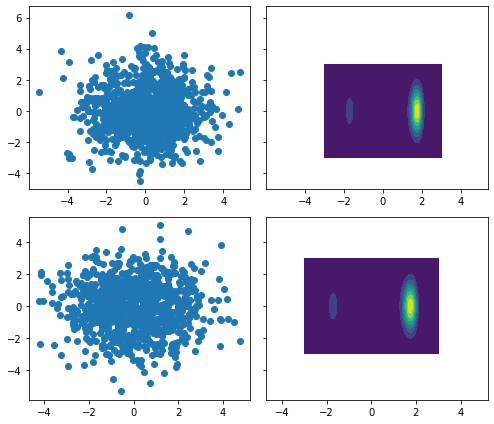

loss: -7.282124399316137, mean log p_x -8.604772276691133:   0%|          | 0/20000 [00:00<?, ?it/s]

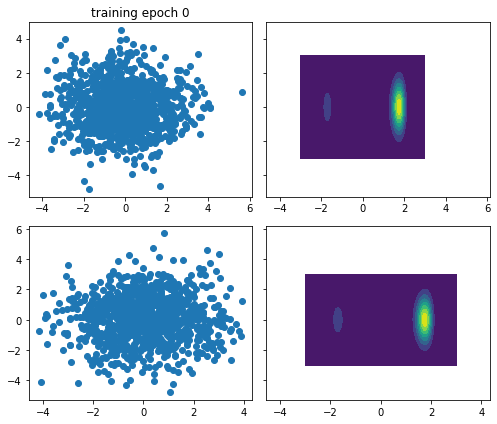

loss: inf, mean log p_x -inf:   5%|▌         | 1000/20000 [02:44<56:00,  5.65it/s]                                

Nan/Inf loss encountered


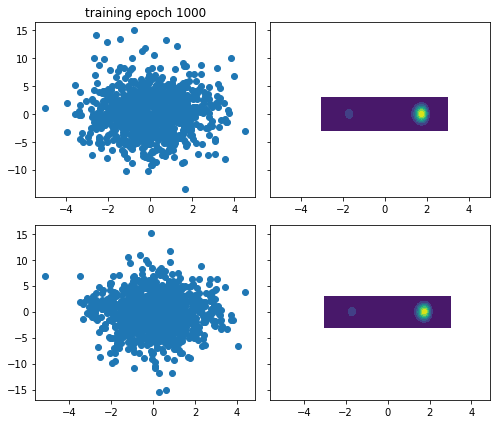

loss: -6.565817576924028, mean log p_x -10.293559104707843:  10%|█         | 2000/20000 [05:38<51:13,  5.86it/s]  

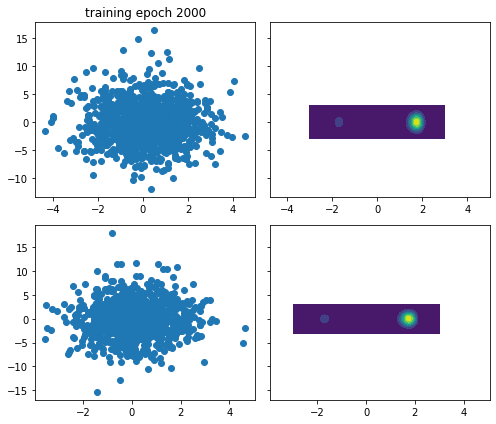

loss: -5.248120948240499, mean log p_x -10.962396794333785:  15%|█▌        | 3000/20000 [08:41<1:02:48,  4.51it/s]

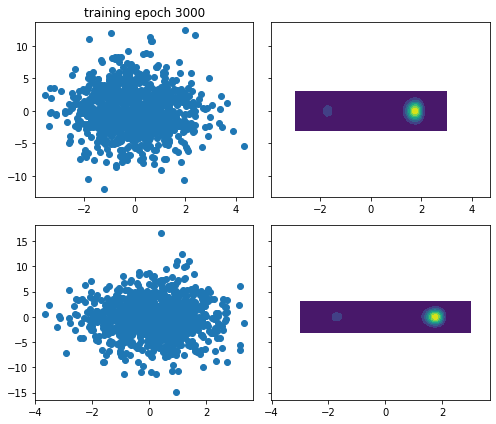

loss: -5.703820545474787, mean log p_x -6.553869317764283:  20%|██        | 4000/20000 [12:17<1:02:26,  4.27it/s]  

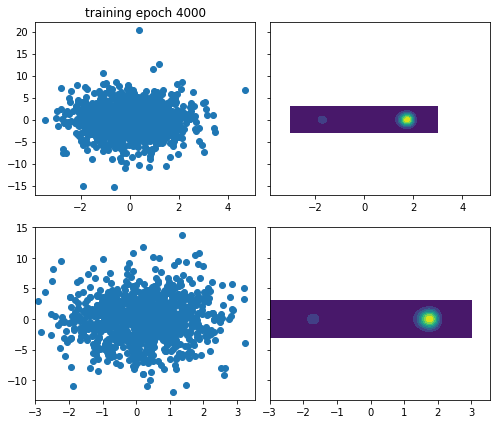

loss: -5.617258213286046, mean log p_x -5.110398851121477:  25%|██▌       | 5000/20000 [15:57<59:23,  4.21it/s]   

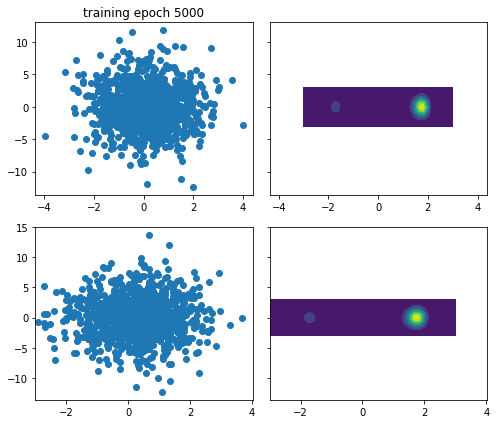

loss: -5.965630354531197, mean log p_x -3.3342028280715144:  30%|███       | 6000/20000 [19:36<52:13,  4.47it/s] 

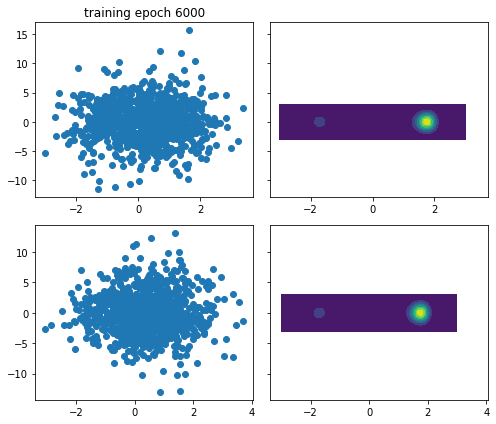

loss: -5.960500817618163, mean log p_x -2.7513274413536655:  35%|███▌      | 7000/20000 [23:18<46:48,  4.63it/s]  

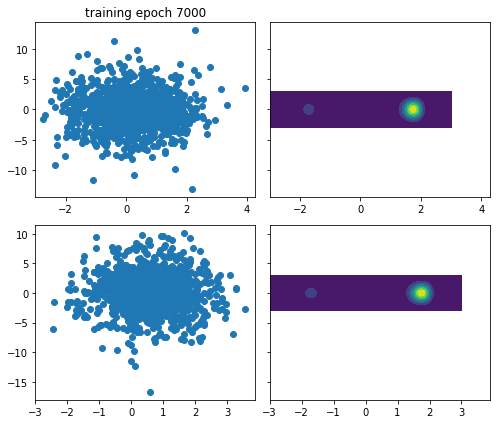

loss: -4.418935216286243, mean log p_x -4.126228477154058:  40%|████      | 8000/20000 [26:59<47:50,  4.18it/s]   

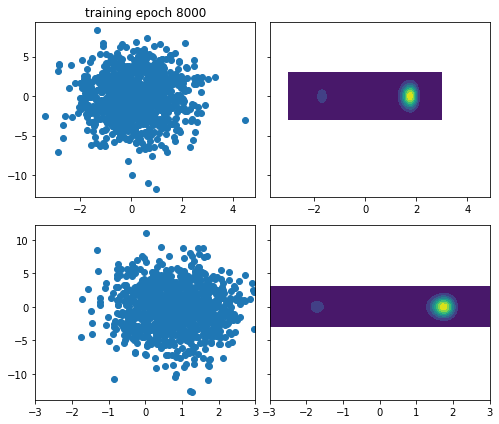

loss: -7.778270716902069, mean log p_x 0.5943705314251243:  45%|████▌     | 9000/20000 [30:39<38:30,  4.76it/s]   

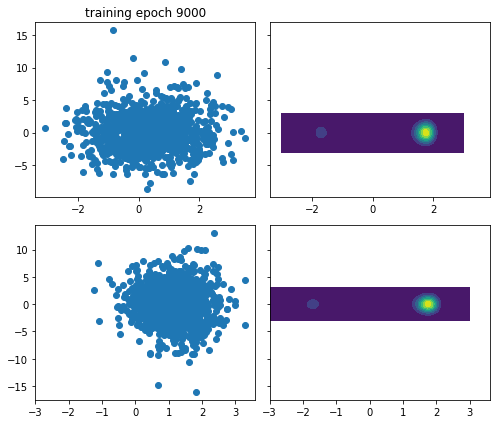

loss: -7.831346554427323, mean log p_x 0.8478335611596817:  50%|█████     | 10000/20000 [34:19<38:30,  4.33it/s]  

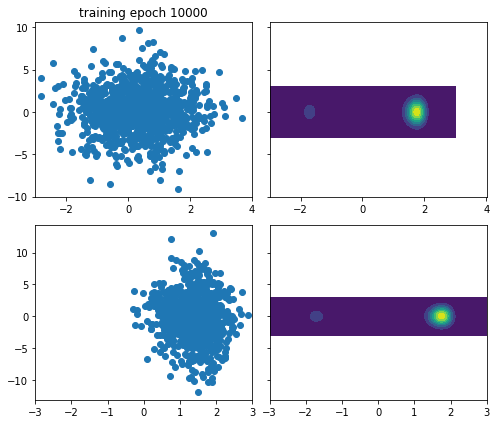

loss: -9.392571351430691, mean log p_x 2.869881182913109:  55%|█████▌    | 11000/20000 [38:54<44:35,  3.36it/s]   

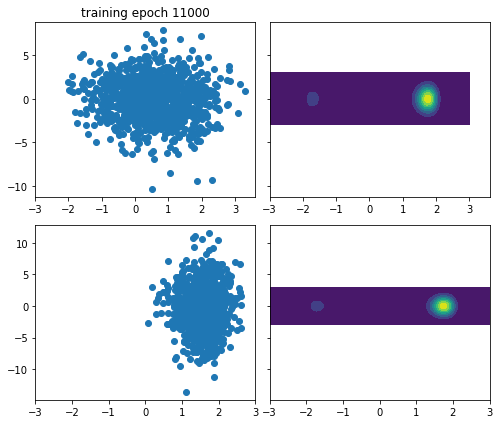

loss: -11.831557339235172, mean log p_x 6.0141776557192514:  60%|██████    | 12000/20000 [44:01<42:07,  3.16it/s] 

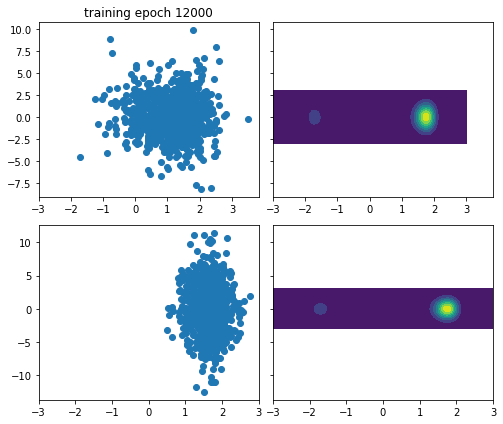

loss: -13.131396040094767, mean log p_x 8.061273283785145:  65%|██████▌   | 13000/20000 [49:06<35:41,  3.27it/s]   

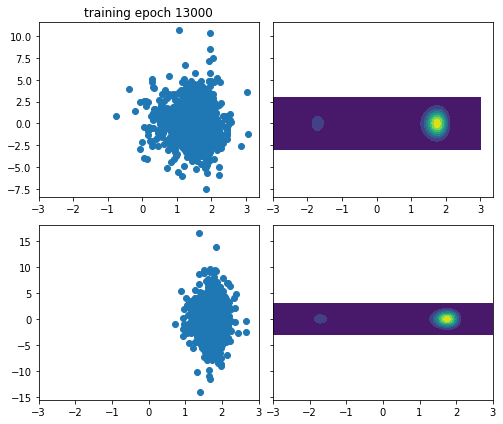

loss: -14.829141241841285, mean log p_x 10.112030246780801:  69%|██████▉   | 13866/20000 [53:33<32:23,  3.16it/s] 

In [ ]:
torch.manual_seed(0)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type=loss_type,
                                   lr=lr, optimizer=optimizer, annealing=annealing, weight_decay=weight_decay)

plotter(tester)
plt.show()
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=5e-3)
    plot_history(history_prior)
    plt.show()
    plotter(tester)
    plt.show()
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)


history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=clip_grad_norm, max_grad_norm=1,
                       intermediate_plots=True, plotting_func=plotter, n_plots=n_plots)
plot_history(history)
plt.show()
plot_divergences(history)
plt.show()
plot_sampling_info(history)
plt.show()

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

plotter(tester, n_samples=1000)
plt.show()